### setting up

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sys import path as syspath
syspath.append("functions/")

import os
from collections import OrderedDict

from copy import deepcopy

import pandas as pd

from data_functions import lett2idx

from sklearn.linear_model import LinearRegression

import pickle

from td_model import ThermodynamicModel

def showdf(a_):
    from IPython.display import display
    display(a_.applymap("{0:0.1f}".format))

In [2]:
shinedalgarno = "aggag"

In [3]:
data = pd.read_excel("review_datasets/Data for Srdjan(2).xlsx", sheet_name=1)

In [4]:
data.columns = [c.strip() for c in data.columns] 

In [5]:
# (~np.isfinite(data["expression in M9"])).sum()

In [6]:
data.columns = [c.lower() for c in data.columns]
data['regulatory sequence'].apply(lambda xi: xi.find(shinedalgarno)).value_counts()

-1    29249
Name: regulatory sequence, dtype: int64

So, no Shine-Delgarno anywhere.

In [7]:
data['promoter length'] = data["regulatory sequence"].apply(len)
data["promoter length"].value_counts()

165    29249
Name: promoter length, dtype: int64

In [8]:
select = np.isfinite(data['expression in m9'])

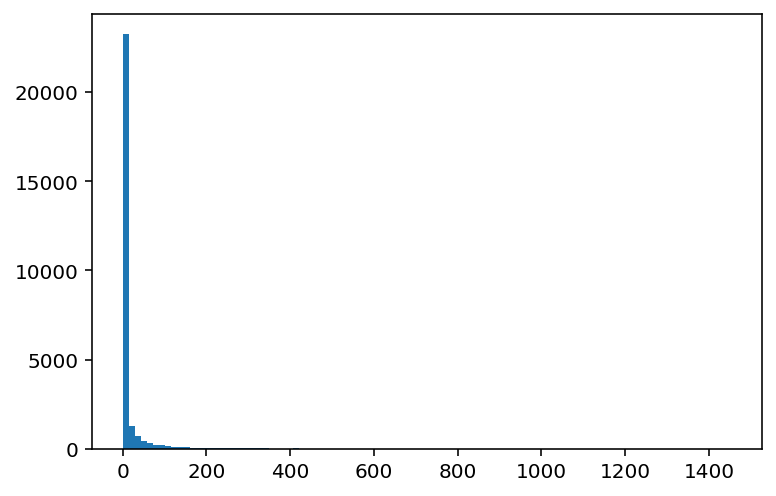

In [9]:
plt.hist(data[select]['expression in m9'],100);

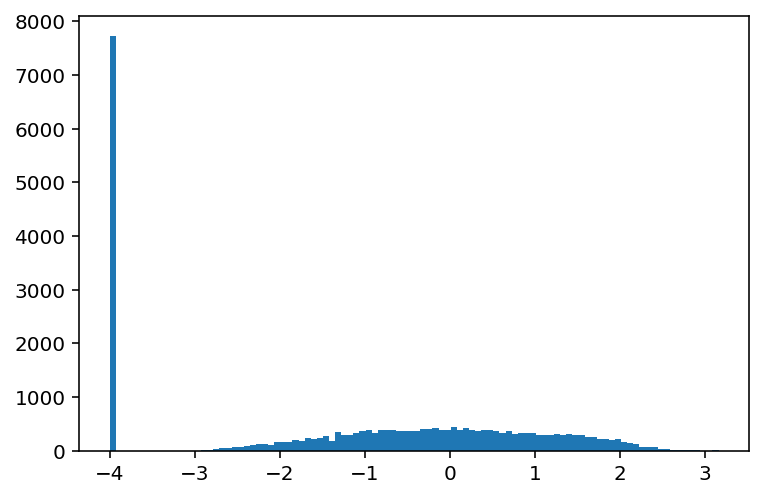

In [10]:
plt.hist(np.log10(.0001+data[select]['expression in m9']),100);

In [11]:
select.mean()

0.9269034838797907

In [26]:
lums = data['expression in m9'].values[select]
lums = np.maximum(lums[lums>0].min(), lums)
lums = np.log10(lums)

In [12]:
numseq = np.array([[lett2idx[l] for l in s.lower()] for s in data['regulatory sequence'][select]],dtype=np.int8)

In [15]:
with open("models/fitted_on_Pr.Pl.36N/model_[5]_extended", "rb") as f:
    full_model = pickle.load(f)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [16]:
with open("models/fitted_on_Pr.Pl.36N/model_[0]_stm.dmp", "rb") as f:
    simple_model = pickle.load(f)

In [17]:
with open("models/fitted_on_Pr/model_[4]_stm+flex+cumul+rbs+rc.dmp", "rb") as f:
    full_model_Pr = pickle.load(f)

In [18]:
with open("models/fitted_on_Pr/model_[0]_stm.dmp", "rb") as f:
    simple_model_Pr = pickle.load(f)

In [19]:
from other_datasets_porting import *

In [20]:
tdmodels = {
    "standard": dict2tdm(simple_model),
    "extended": dict2tdm(full_model),
    "standard[Pr]": dict2tdm(simple_model_Pr),
    "extended[Pr]": dict2tdm(full_model_Pr),
}

In [21]:
bricks = {k:tdmodels[k].sequences2bricks(numseq) for k in tdmodels}

In [22]:
{kk: {k: bricks[kk][k].shape for k in bricks[kk]} for kk in bricks}

{'standard': {'frw': (27111, 134, 1)},
 'extended': {'frw': (27111, 134, 5), 'rc': (27111, 134, 5)},
 'standard[Pr]': {'frw': (27111, 134, 1)},
 'extended[Pr]': {'frw': (27111, 134, 5), 'rc': (27111, 134, 5)}}

In [23]:
numseq.shape

(27111, 165)

## no weights

CPU times: user 9min 25s, sys: 6min 20s, total: 15min 45s
Wall time: 15min 45s


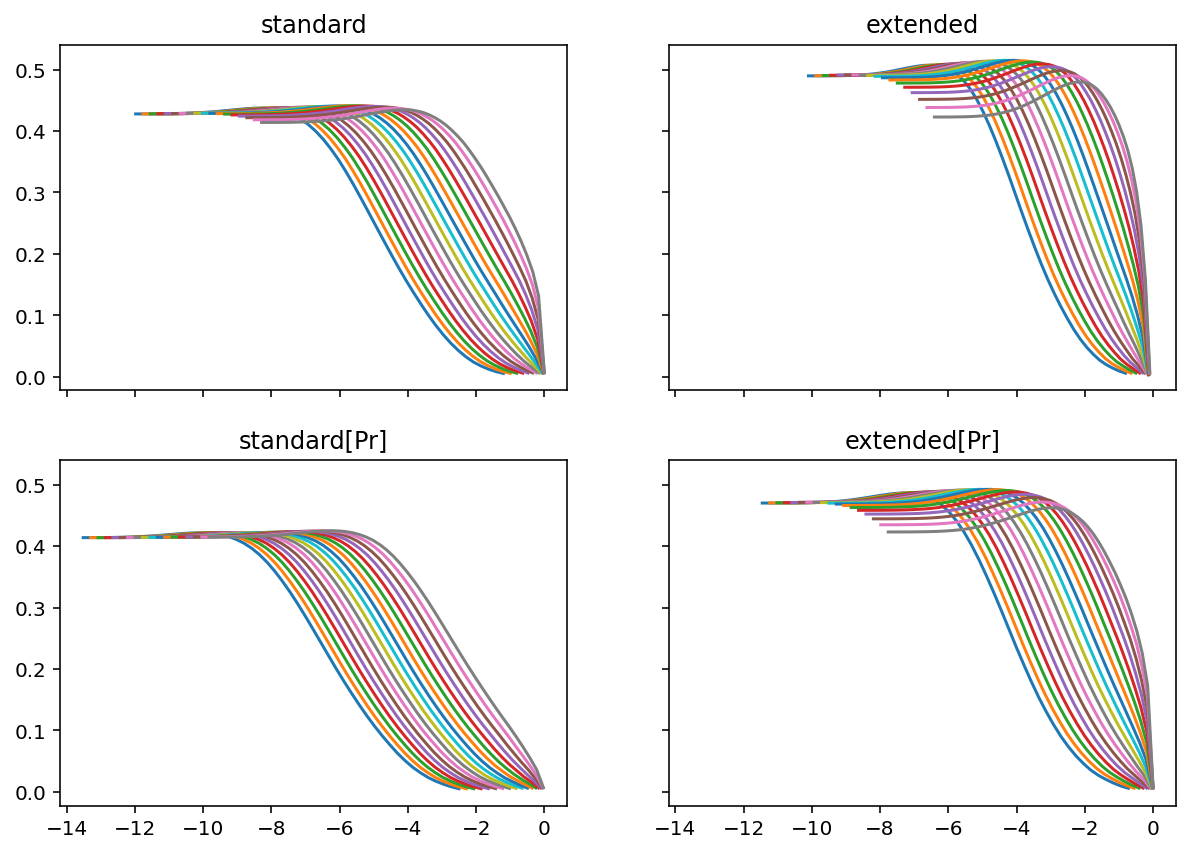

In [27]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax)
    ax.set_title(k)

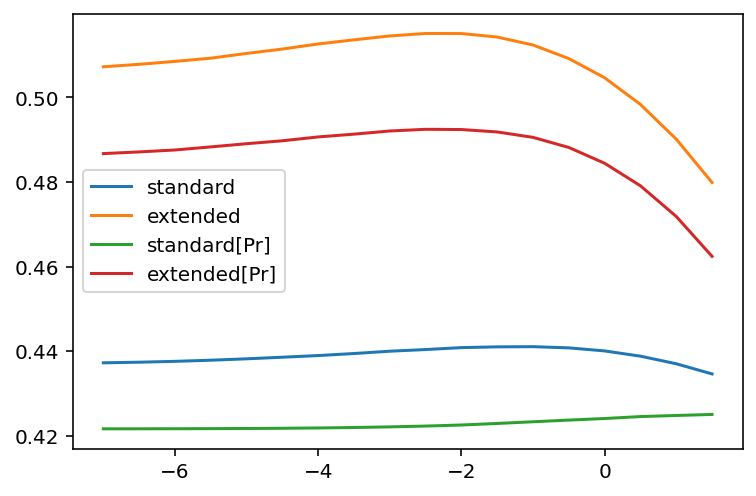

In [28]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

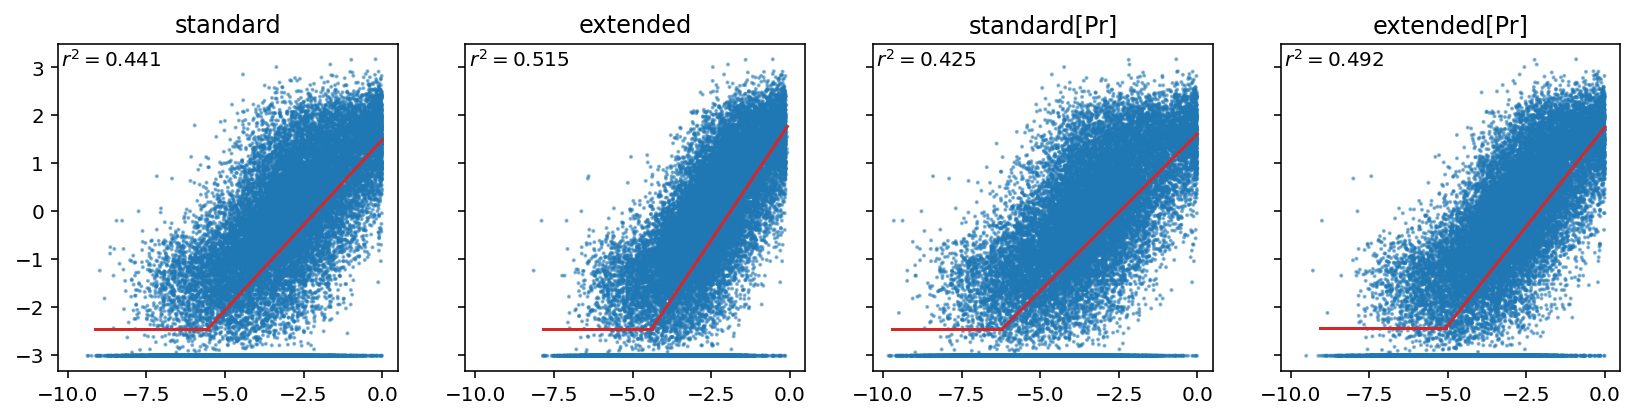

In [29]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax

    )
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

## neglect lum==0

In [31]:
wneg = np.ones(len(lums))
wneg[lums==lums.min()]=0

CPU times: user 9min 10s, sys: 6min 20s, total: 15min 31s
Wall time: 15min 31s


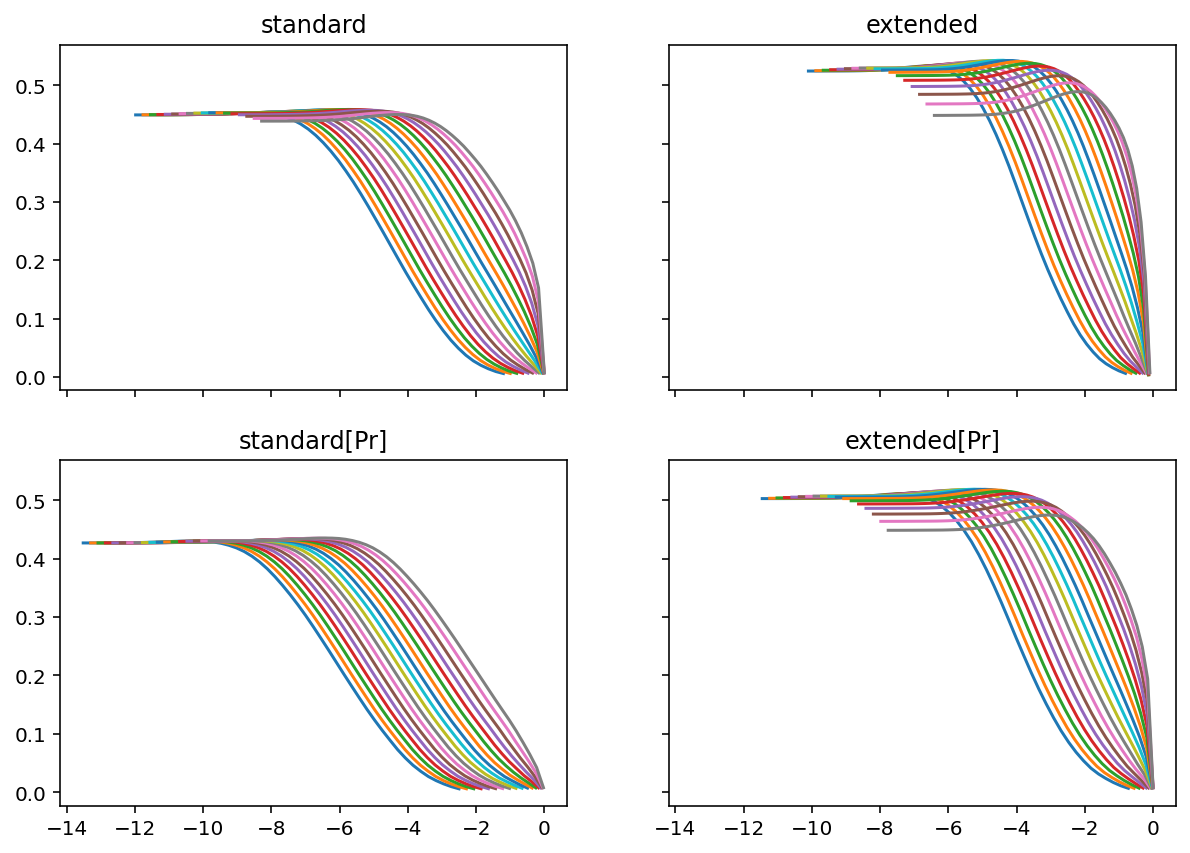

In [32]:
%%time
fig, axs = plt.subplots(2,2,figsize=(10,7), sharey=True, sharex=True)
opt_res = {}
for ax,k in zip(axs.flat, tdmodels):
    opt_res[k] = find_delta_mu(tdmodels[k], bricks[k], delta_mus=np.arange(-7,2,.5), loglums=lums, ax=ax, weights=wneg)
    ax.set_title(k)

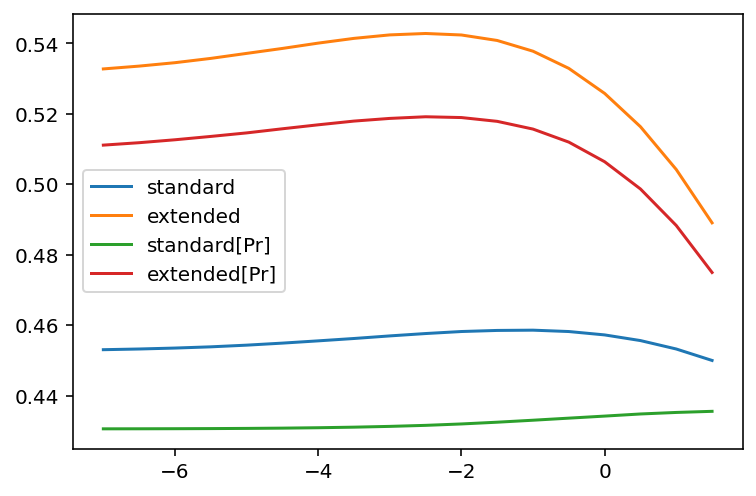

In [33]:
for k in opt_res:
    plt.plot(*opt_res[k]["all_res"], label=k)
plt.legend()

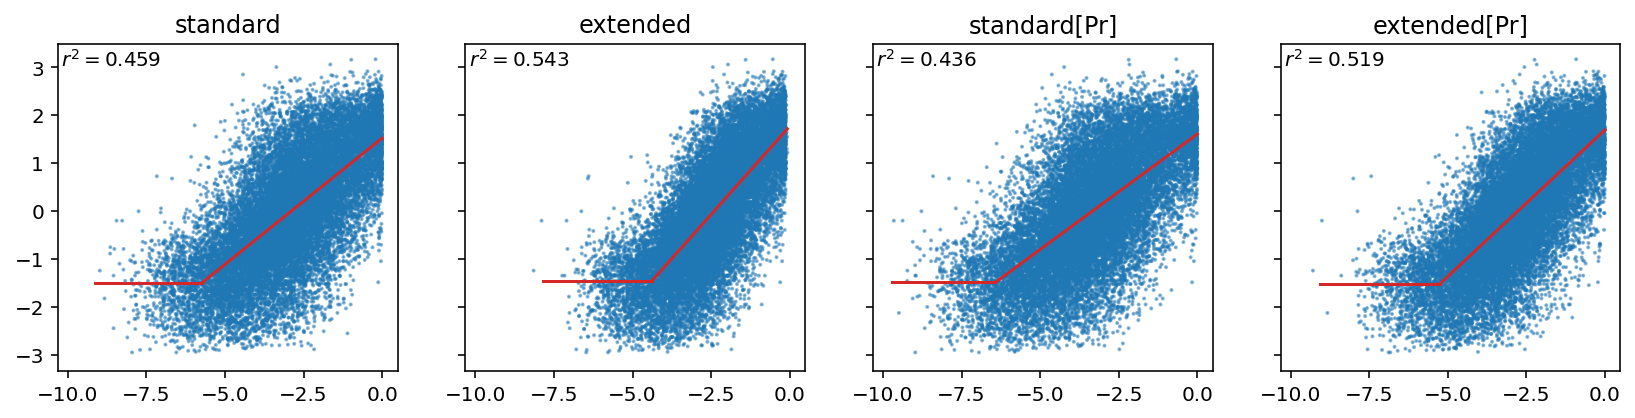

In [34]:
fig, axs = plt.subplots(1,4,figsize=(14,3), sharex=True, sharey=True)
for ax,k in zip(axs.flat, tdmodels):
    evaluate_model(
        tdmodels[k],
        bricks[k],
        delta_mu=opt_res[k]["delta_mu_opt"],
        detection_th=opt_res[k]["detection_th_opt"],
        loglums=lums,
        ax = ax,
        weights=wneg
    )
    ax.set_title(k)
    ax.text(.01,.99,"$r^2=%.3f$"%(opt_res[k]["score_opt"]),va="top",transform=ax.transAxes)

In [12]:
.69**2

0.4760999999999999